Saving test.csv to test (6).csv
Saving train.csv to train (6).csv
Degree=1, C=0.0, Test Accuracy: 0.1667
Degree=1, C=0.1, Test Accuracy: 0.3667
Degree=1, C=1.0, Test Accuracy: 0.8667
Degree=1, C=10.0, Test Accuracy: 0.9333
Degree=1, C=25.0, Test Accuracy: 0.9333
Degree=1, C=50.0, Test Accuracy: 0.9333
Degree=1, C=75.0, Test Accuracy: 0.9333
Degree=1, C=100.0, Test Accuracy: 0.9333
Degree=1, C=250.0, Test Accuracy: 0.9333
Degree=1, C=500.0, Test Accuracy: 0.9333
Degree=1, C=1000.0, Test Accuracy: 0.9333
Degree=2, C=0.0, Test Accuracy: 0.1667
Degree=2, C=0.1, Test Accuracy: 0.2667
Degree=2, C=1.0, Test Accuracy: 0.5000
Degree=2, C=10.0, Test Accuracy: 0.7667
Degree=2, C=25.0, Test Accuracy: 0.8333
Degree=2, C=50.0, Test Accuracy: 0.8667
Degree=2, C=75.0, Test Accuracy: 0.8667
Degree=2, C=100.0, Test Accuracy: 0.8667
Degree=2, C=250.0, Test Accuracy: 0.8667
Degree=2, C=500.0, Test Accuracy: 0.8667
Degree=2, C=1000.0, Test Accuracy: 0.8667
Degree=3, C=0.0, Test Accuracy: 0.1667
Degree=3, C

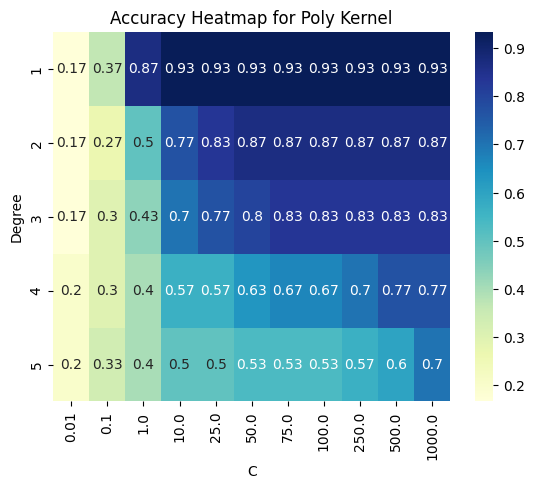

In [45]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from google.colab import files
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt


uploaded = files.upload()

# Load the mobile data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Concatenate train and test data
data = pd.concat([train, test], axis=0)

# Separate features and target variable
X = data.drop(columns=['Label'])
y = data['Label']

# Create a single train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=123)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize variables to track the best model and its accuracy
best_accuracy = 0
best_params = {'degree': None, 'C': None}

# Initialize a list to store scores
scores = []

# Iterate over degrees 1 through 4 and C values
degree_range = range(1, 6) #changing degree range from (1, 5) to (1,6) makes no difference on accuracy score
C_range = [0.01, 0.1, 1, 10, 25, 50, 75, 100, 250, 500, 1000] #change in C_range parameters does not affect accuracy score at all, still achieves 0.9333 accuracy

for degree in degree_range:
    for C in C_range:
        # Initialize the SVC with polynomial kernel
        # uses polynomial degrees (like parabolas, cubic curve) to draw decision boundary
        model = SVC(kernel='poly', degree=degree, C=C, random_state=123)

        # Train the model on the scaled training data
        model.fit(X_train_scaled, y_train)

        # Predict on the test set and calculate accuracy
        y_pred = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)

        print(f"Degree={degree}, C={C:.1f}, Test Accuracy: {accuracy:.4f}")

        # Store the score
        scores.append([degree, C, accuracy])

        # Update the best parameters if current model is better
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params['degree'] = degree
            best_params['C'] = C

# Output the best results
print("\nBest parameters found:")
print(f"Degree={best_params['degree']}, C={best_params['C']}, Test Accuracy: {best_accuracy:.4f}")

# After collecting scores show heatmap of results for this kernel
results = pd.DataFrame(scores, columns=['Degree', 'C', 'Accuracy'])
# Use pivot_table if using pandas version < 1.1.0
heatmap_data = results.pivot_table(index='Degree', columns='C', values='Accuracy')
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu')
plt.title('Accuracy Heatmap for Poly Kernel')
plt.show()

In [46]:
best_accuracy = 0
best_C = None
best_degree = None

# Iterate over degrees 1 through 4 and C values from 60 to 80 with increments of 0.5
degree_range = range(1, 5)
C_range = [0.01, 0.1, 1, 10, 25, 50, 75, 100, 250, 500, 1000]  # Generates values 60, 60.5, ..., 80

for degree in degree_range:
    for C in C_range:
        # Initialize the SVC with polynomial kernel
        # sigmoid kernel uses similar functions to a neural net model, and is able to handle complex boundary decisions well
        model = SVC(kernel='sigmoid', degree=degree, C=C, random_state=123)

        # Train the model on the scaled training data
        model.fit(X_train_scaled, y_train)

        # Predict on the test set and calculate accuracy
        y_pred = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Degree={degree}, C={C:.1f}, Test Accuracy: {accuracy:.4f}")

        # Update the best parameters if the current model is better
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_C = C
            best_degree = degree

# Output the best results
print("\nBest parameters found:")
print(f"Degree={best_degree}, C={best_C}, Test Accuracy: {best_accuracy:.4f}")

Degree=1, C=0.0, Test Accuracy: 0.1667
Degree=1, C=0.1, Test Accuracy: 0.3000
Degree=1, C=1.0, Test Accuracy: 0.9000
Degree=1, C=10.0, Test Accuracy: 0.8333
Degree=1, C=25.0, Test Accuracy: 0.8000
Degree=1, C=50.0, Test Accuracy: 0.8000
Degree=1, C=75.0, Test Accuracy: 0.8000
Degree=1, C=100.0, Test Accuracy: 0.8000
Degree=1, C=250.0, Test Accuracy: 0.8000
Degree=1, C=500.0, Test Accuracy: 0.8000
Degree=1, C=1000.0, Test Accuracy: 0.8000
Degree=2, C=0.0, Test Accuracy: 0.1667
Degree=2, C=0.1, Test Accuracy: 0.3000
Degree=2, C=1.0, Test Accuracy: 0.9000
Degree=2, C=10.0, Test Accuracy: 0.8333
Degree=2, C=25.0, Test Accuracy: 0.8000
Degree=2, C=50.0, Test Accuracy: 0.8000
Degree=2, C=75.0, Test Accuracy: 0.8000
Degree=2, C=100.0, Test Accuracy: 0.8000
Degree=2, C=250.0, Test Accuracy: 0.8000
Degree=2, C=500.0, Test Accuracy: 0.8000
Degree=2, C=1000.0, Test Accuracy: 0.8000
Degree=3, C=0.0, Test Accuracy: 0.1667
Degree=3, C=0.1, Test Accuracy: 0.3000
Degree=3, C=1.0, Test Accuracy: 0.9000

In [47]:
best_accuracy = 0
best_C = None
best_degree = None

# Iterate over degrees 1 through 4 and C values from 60 to 80 with increments of 0.5
degree_range = range(1, 5)
C_range = [0.01, 0.1, 1, 10, 25, 50, 75, 100, 250, 500, 1000]  # Generates values 60, 60.5, ..., 80

for degree in degree_range:
    for C in C_range:
        # Initialize the SVC with polynomial kernel
        # linear kernel uses a straight linear line to draw decision boundary, but isn't ideal for complex classification
        model = SVC(kernel='linear', degree=degree, C=C, random_state=123)

        # Train the model on the scaled training data
        model.fit(X_train_scaled, y_train)

        # Predict on the test set and calculate accuracy
        y_pred = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Degree={degree}, C={C:.1f}, Test Accuracy: {accuracy:.4f}")

        # Update the best parameters if the current model is better
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_C = C
            best_degree = degree

# Output the best results
print("\nBest parameters found:")
print(f"Degree={best_degree}, C={best_C}, Test Accuracy: {best_accuracy:.4f}")

Degree=1, C=0.0, Test Accuracy: 0.3667
Degree=1, C=0.1, Test Accuracy: 0.8333
Degree=1, C=1.0, Test Accuracy: 0.9333
Degree=1, C=10.0, Test Accuracy: 0.9333
Degree=1, C=25.0, Test Accuracy: 0.9333
Degree=1, C=50.0, Test Accuracy: 0.9333
Degree=1, C=75.0, Test Accuracy: 0.9333
Degree=1, C=100.0, Test Accuracy: 0.9333
Degree=1, C=250.0, Test Accuracy: 0.9333
Degree=1, C=500.0, Test Accuracy: 0.9333
Degree=1, C=1000.0, Test Accuracy: 0.9333
Degree=2, C=0.0, Test Accuracy: 0.3667
Degree=2, C=0.1, Test Accuracy: 0.8333
Degree=2, C=1.0, Test Accuracy: 0.9333
Degree=2, C=10.0, Test Accuracy: 0.9333
Degree=2, C=25.0, Test Accuracy: 0.9333
Degree=2, C=50.0, Test Accuracy: 0.9333
Degree=2, C=75.0, Test Accuracy: 0.9333
Degree=2, C=100.0, Test Accuracy: 0.9333
Degree=2, C=250.0, Test Accuracy: 0.9333
Degree=2, C=500.0, Test Accuracy: 0.9333
Degree=2, C=1000.0, Test Accuracy: 0.9333
Degree=3, C=0.0, Test Accuracy: 0.3667
Degree=3, C=0.1, Test Accuracy: 0.8333
Degree=3, C=1.0, Test Accuracy: 0.9333

In [48]:
# Initialize variables to track the best model and its accuracy
best_accuracy = 0
best_params = {'gamma': None, 'C': None}

# Define ranges for gamma and C
gamma_range = np.arange(0.0005, 0.0101, 0.0001)
C_range = [0.01, 0.1, 1, 10, 50, 100, 500, 1000]


# Iterate over all combinations of gamma and C
for gamma in gamma_range:
    for C in C_range:
        # Initialize the SVC with Gaussian (RBF) kernel
        # rbf kernel is great for most use-cases and uses distance in-between points to draw decision boundaries to give good accuracy reports
        model = SVC(kernel='rbf', gamma=gamma, C=C, random_state=123)

        # Train the model on the scaled training data
        model.fit(X_train_scaled, y_train)

        # Predict on the test set and calculate accuracy
        y_pred = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Gamma={gamma:.4f}, C={C:.1f}, Test Accuracy: {accuracy:.4f}")

        # Update best parameters if current model is better
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params['gamma'] = gamma
            best_params['C'] = C

# Output the best results
print(f"Best gamma: {best_params['gamma']}")
print(f"Best C: {best_params['C']}")
print(f"Best Accuracy: {best_accuracy:.4f}")

Gamma=0.0005, C=0.0, Test Accuracy: 0.1667
Gamma=0.0005, C=0.1, Test Accuracy: 0.1667
Gamma=0.0005, C=1.0, Test Accuracy: 0.1667
Gamma=0.0005, C=10.0, Test Accuracy: 0.3667
Gamma=0.0005, C=50.0, Test Accuracy: 0.8333
Gamma=0.0005, C=100.0, Test Accuracy: 0.8333
Gamma=0.0005, C=500.0, Test Accuracy: 0.9333
Gamma=0.0005, C=1000.0, Test Accuracy: 0.9333
Gamma=0.0006, C=0.0, Test Accuracy: 0.1667
Gamma=0.0006, C=0.1, Test Accuracy: 0.1667
Gamma=0.0006, C=1.0, Test Accuracy: 0.1667
Gamma=0.0006, C=10.0, Test Accuracy: 0.4333
Gamma=0.0006, C=50.0, Test Accuracy: 0.8333
Gamma=0.0006, C=100.0, Test Accuracy: 0.9000
Gamma=0.0006, C=500.0, Test Accuracy: 0.9333
Gamma=0.0006, C=1000.0, Test Accuracy: 0.9333
Gamma=0.0007, C=0.0, Test Accuracy: 0.1667
Gamma=0.0007, C=0.1, Test Accuracy: 0.1667
Gamma=0.0007, C=1.0, Test Accuracy: 0.1667
Gamma=0.0007, C=10.0, Test Accuracy: 0.4333
Gamma=0.0007, C=50.0, Test Accuracy: 0.8333
Gamma=0.0007, C=100.0, Test Accuracy: 0.9000
Gamma=0.0007, C=500.0, Test Accu

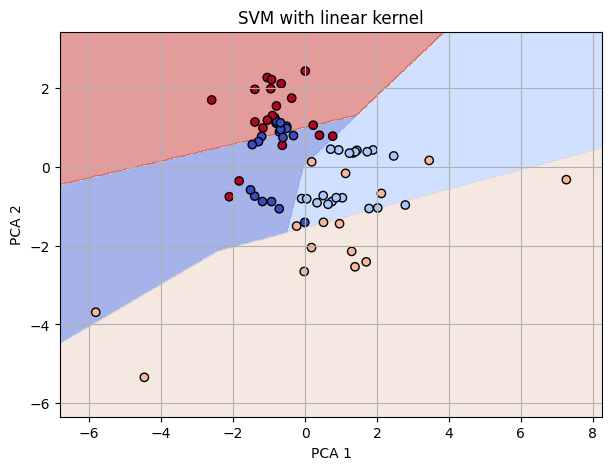

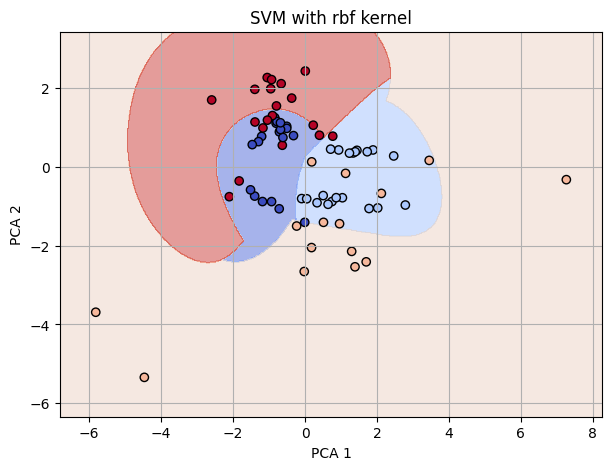

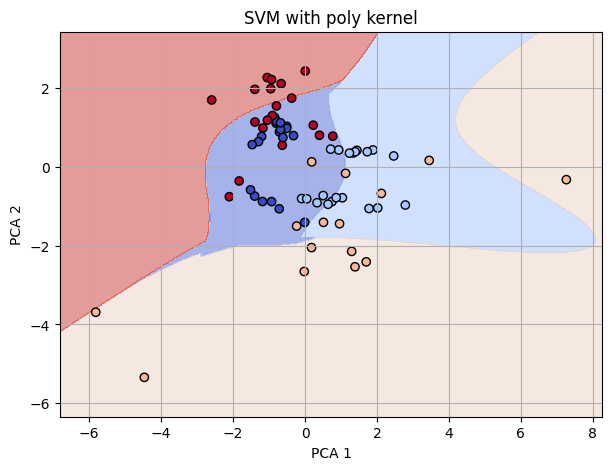

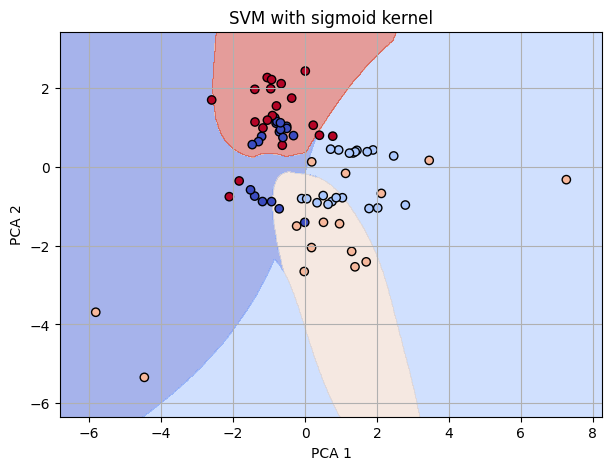

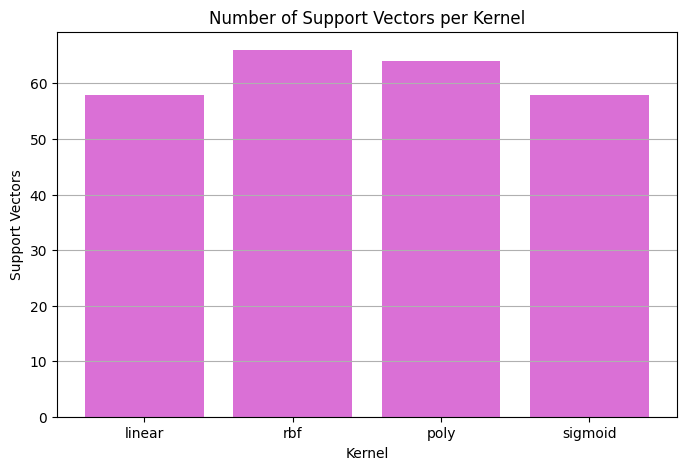

In [49]:
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import numpy as np

# Function to plot decision boundary and return the trained model
def plot_kernel_decision_boundary(kernel, X_pca, y):
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    model = SVC(kernel=kernel, gamma='scale', C=1).fit(X_pca, y_encoded)

    h = 0.02
    x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
    y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid_points).reshape(xx.shape)

    plt.figure(figsize=(7, 5))
    plt.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.5)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_encoded, cmap='coolwarm', edgecolors='k')
    plt.title(f"SVM with {kernel} kernel")
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.grid(True)
    plt.show()

    return model

# Kernel list and storage
kernels = ['linear', 'rbf', 'poly', 'sigmoid']
all_models = []

# Run and store each kernel's model
for k in kernels:
    trained_model = plot_kernel_decision_boundary(k, X_pca, y)
    all_models.append(trained_model)

# Bar plot of number of support vectors per kernel
plt.figure(figsize=(8, 5))
plt.bar(kernels, [model.n_support_.sum() for model in all_models], color='orchid')
plt.title("Number of Support Vectors per Kernel")
plt.xlabel("Kernel")
plt.ylabel("Support Vectors")
plt.grid(axis='y')
plt.show()

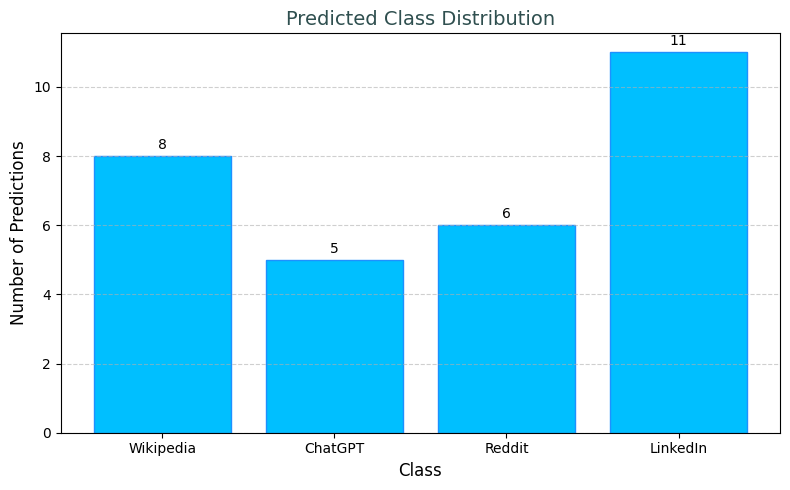

In [50]:
# visualizing per class predictions
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Count the number of predictions for each class
predicted_counts = Counter(y_pred)

# Map label indices back to names
label_names = {
    0: 'ChatGPT',
    1: 'Reddit',
    2: 'Wikipedia',
    3: 'LinkedIn'
}

# Prepare data for plotting
labels = [label_names.get(i, f"{i}") for i in predicted_counts.keys()]
counts = [predicted_counts[i] for i in predicted_counts.keys()]

# Create bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, counts, color='deepskyblue', edgecolor='dodgerblue')
plt.title('Predicted Class Distribution', fontsize=14, color='darkslategrey')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Predictions', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add value labels on top
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.2, int(yval), ha='center', fontsize=10)

plt.tight_layout()
plt.show()

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Best parameters: {'C': 1, 'degree': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV score: 0.9111

Test set classification report:
              precision    recall  f1-score   support

     ChatGPT       1.00      1.00      1.00         5
    LinkedIn       0.77      1.00      0.87        10
      Reddit       1.00      0.57      0.73         7
   Wikipedia       0.88      0.88      0.88         8

    accuracy                           0.87        30
   macro avg       0.91      0.86      0.87        30
weighted avg       0.89      0.87      0.86        30



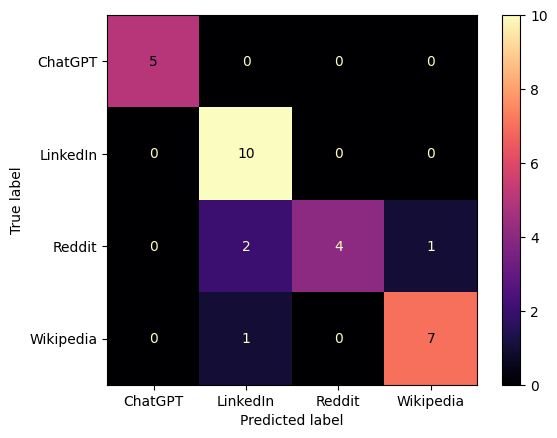

In [51]:
# GridSearch for SVM
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'kernel': ['poly', 'sigmoid', 'rbf'],
    'gamma': ['scale', 'auto'],
    'degree': [1, 2, 3, 4, 5],
    'C': [0.01, 0.1, 1, 10, 50, 100, 500, 1000]
}

# Create the SVM model
model = SVC(random_state=123)

# Set up the GridSearch
# GridSearch uses stratified k-fold by default, so by setting cv to 5, it thoroughly cross-validates already using the single tts done earlier
grid = GridSearchCV(model, param_grid, cv=5, verbose=2, n_jobs=-1) #n-jobs is to help with runtime (setting to -1 splits workload across all the cores)

# Fit the grid search to training data
grid.fit(X_train_scaled, y_train)

# After fitting, best parameters are:
print(f"Best parameters: {grid.best_params_}")
print(f"Best CV score: {grid.best_score_:.4f}")

# Evaluate on test set
y_pred = grid.predict(X_test_scaled)
print("\nTest set classification report:")
print(classification_report(y_test, y_pred))

# visualize the confusion matrix of findings
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(grid, X_test_scaled, y_test, cmap='magma')